In [207]:
# whole code using random forest clasifier

In [208]:
import os
import pandas as pd

!pip install hvplot
import hvplot.pandas

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#define spark version
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 229 kB in 2s (131 kB/s)
Reading package lists... Done


In [209]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Demographics").getOrCreate()

In [210]:
#Read in the data from the group github repo
from pyspark import SparkFiles
url = "https://raw.githubusercontent.com/AlexFeeney/Project4_Group3/main/Data/healthcare-dataset-stroke-data.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("healthcare-dataset-stroke-data.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

In [211]:
#convert to pandas df
pandas_df = df.toPandas()


#check pandas df
pandas_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1


In [212]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [213]:
df_stroke=pandas_df
#df_stroke.head()

In [214]:
df_stroke["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [215]:
df_stroke["ever_married"].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [216]:
# NO TO BE 0 AND YES IS 1 IN EVER_MARRIED COLUMN

def ever_married(x):
    if x=="Yes":
        return 1
    else:
        return 0

df_stroke["ever_married"]=df_stroke["ever_married"].map(ever_married)
df_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,1,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,1,Self-employed,Rural,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,1,Private,Urban,83.75,N/A,never smoked,0
5106,44873,Female,81,0,0,1,Self-employed,Urban,125.2,40,never smoked,0
5107,19723,Female,35,0,0,1,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51,0,0,1,Private,Rural,166.29,25.6,formerly smoked,0


In [217]:
df_stroke["work_type"].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [218]:
df_stroke["Residence_type"].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [219]:
#1= urban, 0=rural
def Residence_type(x):
    if x=="Urban":
        return 1
    else:
        return 0

df_stroke["Residence_type"]=df_stroke["Residence_type"].map(Residence_type)
df_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,1,Self-employed,0,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79,1,0,1,Self-employed,0,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,1,Private,1,83.75,N/A,never smoked,0
5106,44873,Female,81,0,0,1,Self-employed,1,125.2,40,never smoked,0
5107,19723,Female,35,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [221]:
# Step 1: Exclude 'id' and 'age' columns from df_stroke
df_stroke_subset = df_stroke.drop(columns=['id','bmi','avg_glucose_level','age','stroke'])

# Step 2: Get dummies for the remaining columns
df_dummies = pd.get_dummies(df_stroke_subset)

# Step 3: Concatenate 'id' and 'age' columns back to df_dummies
df_dummies[['id','bmi','avg_glucose_level', 'age','stroke']] = df_stroke[['id','bmi','avg_glucose_level', 'age','stroke']]

# Step 4: Ensure 'id' and 'age' columns are in the correct order
df_dummies = df_dummies[['id','bmi','avg_glucose_level','age','stroke'] + [col for col in df_dummies.columns if col not in ['id','bmi','avg_glucose_level', 'age','stroke']]]

# Now df_dummies will have binary columns for all categorical variables and 'id' and 'age' columns with their original values.
df_dummies

,id,bmi,avg_glucose_level,age,stroke,ever_married,Residence_type,gender_Female,gender_Male,gender_Other,...,heart_disease_1,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,36.6,228.69,67,1,1,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,51676,N/A,202.21,61,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,31112,32.5,105.92,80,1,1,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
3,60182,34.4,171.23,49,1,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,1665,24,174.12,79,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,N/A,83.75,80,0,1,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
5106,44873,40,125.2,81,0,1,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0
5107,19723,30.6,82.99,35,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
5108,37544,25.6,166.29,51,0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [222]:

print(df_dummies.columns)


Index(['id', 'bmi', 'avg_glucose_level', 'age', 'stroke', 'ever_married',
       'Residence_type', 'gender_Female', 'gender_Male', 'gender_Other',
       'hypertension_0', 'hypertension_1', 'heart_disease_0',
       'heart_disease_1', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


In [224]:

# df_dummies is your DataFrame containing dummy variables


# Extracting binary target variable
y = df_dummies["stroke"]
 # Assuming stroke_1 represents the positive class

# Dropping unnecessary columns from the feature matrix
X = df_dummies.drop(columns=["stroke"])

# Display the first few rows of the binary target variable
print(y.head())


0    1
1    1
2    1
3    1
4    1
Name: stroke, dtype: object


In [225]:
X.head()

,id,bmi,avg_glucose_level,age,ever_married,Residence_type,gender_Female,gender_Male,gender_Other,hypertension_0,...,heart_disease_1,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,36.6,228.69,67,1,1,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
1,51676,N/A,202.21,61,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,31112,32.5,105.92,80,1,0,0,1,0,1,...,1,0,0,1,0,0,0,0,1,0
3,60182,34.4,171.23,49,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
4,1665,24,174.12,79,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [237]:
df_dummies = df_dummies.drop(columns=['id'])

In [238]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Making Predictions Using The Random Forest model

In [239]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Replace 'N/A' with NaN in the specified columns
columns_to_replace_na = ['bmi', 'avg_glucose_level', 'age']
df_dummies[columns_to_replace_na] = df_dummies[columns_to_replace_na].replace('N/A', np.nan)
# Separate numeric and categorical columns
numeric_columns = ['bmi', 'avg_glucose_level', 'age']
categorical_columns = [col for col in df_dummies.columns if col not in numeric_columns]

# Impute missing values for numeric columns with the mean
numeric_imputer = SimpleImputer(strategy='mean')
df_dummies[numeric_columns] = numeric_imputer.fit_transform(df_dummies[numeric_columns])

# Impute missing values for categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_dummies[categorical_columns] = categorical_imputer.fit_transform(df_dummies[categorical_columns])

# Separate features (X) and target variable (y)
X = df_dummies.drop(columns=['stroke'])
y = df_dummies['stroke']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestClassifier instance
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=78)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix:\n", cm_df)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0          959            1
Actual 1           62            0
Accuracy: 0.9383561643835616
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



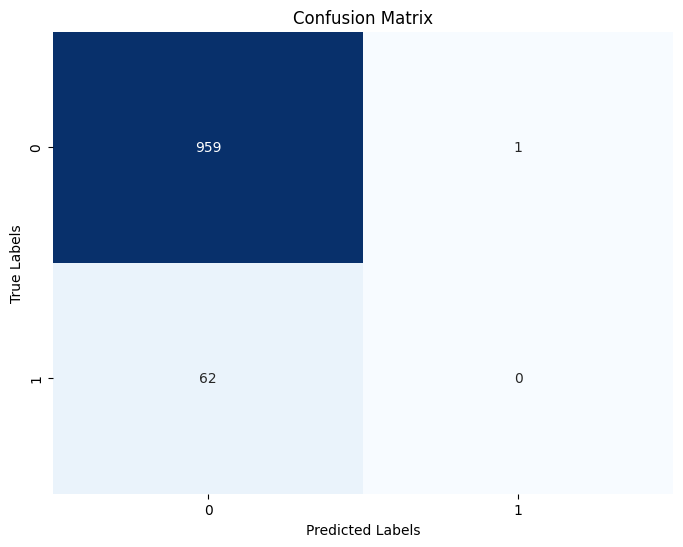

In [240]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



# Feature Importance

In [241]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_classifier.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_classifier.feature_importances_, X.columns), reverse=True)

[(0.2618613161428492, 'avg_glucose_level'),
 (0.24296653288438647, 'age'),
 (0.22309251354924128, 'bmi'),
 (0.035261650370215836, 'Residence_type'),
 (0.021206351605537306, 'ever_married'),
 (0.020760940879324175, 'work_type_Private'),
 (0.020733599583422566, 'smoking_status_never smoked'),
 (0.019361507090779828, 'gender_Male'),
 (0.018806079044460244, 'gender_Female'),
 (0.018462703982412097, 'work_type_Self-employed'),
 (0.017646936947963026, 'smoking_status_formerly smoked'),
 (0.017645168299903872, 'smoking_status_smokes'),
 (0.01700435401776469, 'smoking_status_Unknown'),
 (0.013778517380449974, 'work_type_Govt_job'),
 (0.013101685494920697, 'heart_disease_1'),
 (0.012718377002893742, 'hypertension_0'),
 (0.012329906298637614, 'hypertension_1'),
 (0.012155119100577675, 'heart_disease_0'),
 (0.0010787932332840982, 'work_type_children'),
 (2.794709097572483e-05, 'work_type_Never_worked'),
 (0.0, 'gender_Other')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

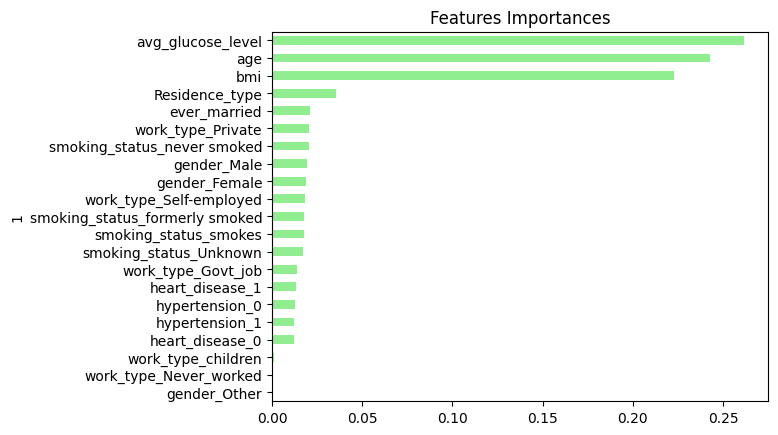

In [242]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip( rf_classifier.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

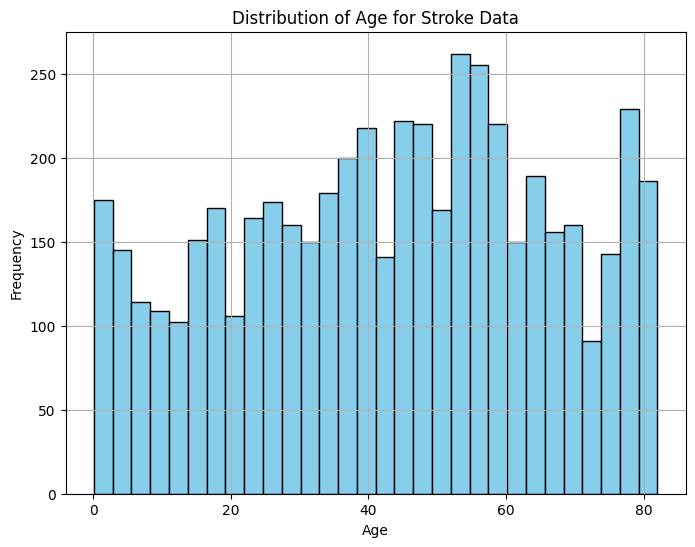

In [243]:
import matplotlib.pyplot as plt

# Assuming df_dummies is your DataFrame with stroke data
# Replace 'age' with the name of the column containing age data
age_data = df_dummies['age']

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(age_data, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age for Stroke Data')
plt.grid(True)
plt.show()


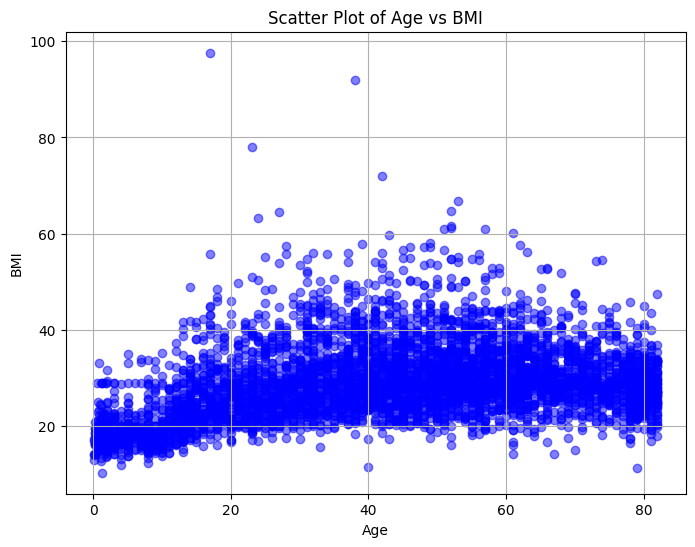

In [244]:
import matplotlib.pyplot as plt

# Assuming df_dummies is your DataFrame with stroke data
# Replace 'age' and 'bmi' with the actual column names in your DataFrame
age_data = df_dummies['age']
bmi_data = df_dummies['bmi']

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(age_data, bmi_data, color='blue', alpha=0.5)
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Scatter Plot of Age vs BMI')
plt.grid(True)
plt.show()
